In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import poisson
from scipy.optimize import fsolve

In [2]:
def FS_Bagnoli(N, m, seed):
    """
    Create a scale free network with gamma~2.
    The network is created using the Barabasi-Albert model plus a new edge from a random node to the new node.
    
    Parameters
    ----------
    N : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes (preferential attachment)
    seed : int
        Seed for random number generator

    Returns
    -------
    G : networkx graph
        Scale free network
    """
    # create a directed graph
    G = nx.DiGraph()
    # add the first m nodes as a ring
    for i in range(m):
        G.add_node(i)
        G.add_edge(i, (i+1)%m)
    # add the rest of the nodes
    np.random.seed(seed)
    for i in range(m, N):
        # get the in-degree of each node
        in_degree = np.array(list(G.in_degree()))
        # get the probability of each node (preferential attachment)
        prob = in_degree[:,1]/np.sum(in_degree[:,1])
        # choose m nodes to attach to
        attach_to = np.random.choice(in_degree[:,0], m, p=prob, replace=False)
        # add the new node
        G.add_node(i)
        # add the edges
        for j in attach_to:
            G.add_edge(i, j)
        # choose another node to attach randomly and add an in-edge of the new node
        j = np.random.choice(range(i))
        G.add_edge(j, i)
        # print every N/10 nodes
        # if i%(N//10) == 0:
        #     print("Node", i, "of", N, "added.")
    return G


def risk(J, k, s, alpha=1, H=0):
    return np.exp(-(H+J*(s/k)**alpha))


def SIS_hom(k, ck, beta):
    """
    Compute the homogeneous SIS model.
    
    Parameters
    ----------
    k : int
        Degree of each node
    ck : array
        Probability of being infectious 
    beta : float
        Infection rate

    Returns
    -------
    ck1 : array
        Probability of being infectious for a node with degree k at time t+1
    """
    ck1 = 1 - (1 - beta*ck)**k
    return ck1   


def SIS_hom_critical_J(beta, z):
    ans = np.array([])
    for b in beta:
        tmp = z*np.log(z*b)
        if tmp < 0:
            tmp = 0
        ans = np.append(ans, tmp)
    return ans


def critical_boundary(J, beta, z, alpha):
    """
    Compute the critical boundary function for the SIS model in mean-field approxiation, for a Erdos-Renyi network. (Poisson degree distribution)

    Parameters
    ----------
    J : float
        Local perception of risk (linear term)
    z : float
        Average degree
    alpha : float
        Local perception of risk (non-linear term)
    beta : float
        Infection rate

    Returns
    -------
    ans : float
        Critical boundary equation
    """
    P = poisson(z)
    k = np.arange(1, 20, 1)
    ans = z/beta - np.sum(np.exp(-J/k**alpha)*k**2*P.pmf(k))
    return ans


def SIS_dynamics(net, J, N_iter, m, beta, risk, alpha=1, stop_if_con=True, count_time=False, tol=0.001):
    """
    Compute the SIS dynamics for a given network.
    """
    if count_time:
        stop_if_con = False
    # initial condition
    N = nx.number_of_nodes(net)
    # clean the network
    nx.set_node_attributes(net, 0, 'state')
    if count_time:
        nx.set_node_attributes(net, 0, 'time')
    # randomly choose m nodes to be infected
    initial_infected = np.random.choice(range(N), m, replace=False)
    for node in initial_infected:
        net.nodes[node]['state'] = 1
    # check if the network is directed
    if nx.is_directed(net):
        directed = True 
    else:
        directed = False

    for i in range(N_iter):
        # if i%100 == 0:
        #     print('iteration', i)
        new_infected=[]
        # for each node, if it is susceptible, check if it has infected neighbors
        if directed:
            for node in net.nodes:
                if net.nodes[node]['state'] == 0:
                    # get the neighbors that are pointing it
                    neighbors_in = list(net.predecessors(node))
                    # count the number of infected neighbors
                    n_infected = np.sum([net.nodes[neigh]['state'] for neigh in neighbors_in])
                    if n_infected > 0:
                        # compute the risk of infection
                        beta_risk = beta*risk(J, net.in_degree(node), n_infected, alpha)
                        # infect with probability beta_risk
                        for j in range(n_infected):
                            if np.random.rand() < beta_risk:
                                new_infected.append(node)
                                break
        else:
            for node in net.nodes:
                if net.nodes[node]['state'] == 0:
                    # get the neighbors of the node
                    neighbors = list(net.neighbors(node))
                    # count the number of infected neighbors
                    n_infected = np.sum([net.nodes[neighbor]['state'] for neighbor in neighbors])
                    if n_infected > 0:
                        # compute the risk for that node
                        beta_risk = beta*risk(J, net.degree[node], n_infected, alpha=alpha)
                        # infect the node with probability beta_risk, update the network later
                        for j in range(n_infected):
                            if np.random.rand() < beta_risk:
                                new_infected.append(node)
                                break
        if count_time:
            for node in net.nodes:
                if net.nodes[node]['state'] == 1:
                    net.nodes[node]['time'] += 1/N_iter
            for node in new_infected:
                net.nodes[node]['time'] += 1/N_iter

        # heal the infected nodes
        for node in net.nodes:
            if net.nodes[node]['state'] == 1:
                net.nodes[node]['state'] = 0
        # update the infected nodes
        for node in new_infected:
            net.nodes[node]['state'] = 1

        # check convergence
        infected = len(new_infected)
        if stop_if_con:
            if (infected/N < tol) or (infected/N > 0.2):
                #print('J', J, 'iteration', i, 'infected', infected/N)
                return infected/N
        #print('J', J, 'iteration', i, 'infected', infected/N)   
    if count_time:
        time = np.array([net.nodes[node]['time'] for node in net.nodes])
        if directed:
            # in degree of each node
            degree = np.array([net.in_degree(node) for node in net.nodes])
        else:
            # degree of each node
            degree = np.array([net.degree(node) for node in net.nodes])
        # group the nodes by degree and compute the average time
        degree_unique = np.unique(degree)
        time = np.array([np.mean(time[degree==d]) for d in degree_unique])
        return time, degree_unique

    else:
        #print('J', J, 'iteration', i, 'infected', infected/N)
        return infected/N
    
    
def numerical_Jc(N_sim, param_list, J_list, is_beta_var ,SIS_dynamics, **kwargs):
    """
    Compute numerically the critical boundary of perception of risk Jc for a given network and parameters.

    Parameters
    ----------
    N_sim : int
        Number of simulations
    param_list : array
        Infection rate or alpha
    J_list : array
        Local perception of risk
    is_beta_var : bool
        True if beta is variable, False if alpha is variable
    SIS_dynamics : function
        SIS dynamics function
    **kwargs : dict
        Network and parameters

    Returns
    -------
    J_critical_list : array
        Critical boundary (if N_sim = 1)
    or (J_critical_list_mean, J_critical_list_var) : tuple (if N_sim > 1)
        Mean and variance of the critical boundary
    """
    # extract tol from kwargs
    tol = kwargs['tol']
    # initialize the list of critical boundaries
    J_critical_list = np.array([])
    for i in range(N_sim):
        for beta in param_list:
            not_die = False
            for J in J_list:
                if is_beta_var:
                    if SIS_dynamics(**kwargs, beta=beta, J=J) >= tol:
                        not_die = True
                        J_critical_list = np.append(J_critical_list, J)
                        #print(J)
                        break
                else:
                    if SIS_dynamics(**kwargs, alpha=beta, J=J) >= tol:
                        not_die = True
                        J_critical_list = np.append(J_critical_list, J)
                        #print(J)
                        break
            if not not_die:
                J_critical_list = np.append(J_critical_list, 0)
                #print(0)
    if N_sim > 1:
        # mean and variance
        J_critical_list_mean = J_critical_list.reshape(N_sim, len(param_list)).mean(axis=0)
        J_critical_list_var = J_critical_list.reshape(N_sim, len(param_list)).var(axis=0)
        return J_critical_list_mean, J_critical_list_var
    else:
        return J_critical_list

#### Distribution of in-degrees and out-degrees with respect to the degree, for Bagnoli's Network

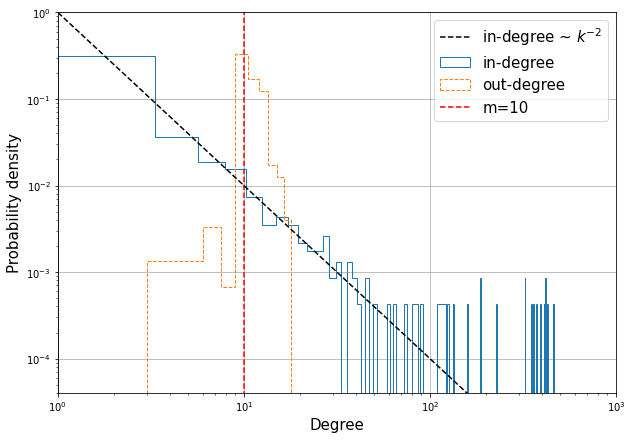

In [3]:
# network
N = 1000
m = 10
G = FS_Bagnoli(N, m, 27)

# get the in-degrees and out-degrees
in_degree = np.array(list(G.in_degree()))[:,1]
out_degree = np.array(list(G.out_degree()))[:,1]

# plot (log-log)
plt.figure(figsize=(10,7))
plt.hist(in_degree, bins=N//5, histtype='step', density=True)
# dashed line
plt.hist(out_degree, bins=10, histtype='step', density=True, linestyle='dashed')
plt.plot(np.linspace(1, N, 1000), np.linspace(1, N, 1000)**(-2), '--', color='black')
plt.vlines(m, -10, 10, colors='r', linestyles='dashed')
# legend
plt.legend(['in-degree ~ $k^{-2}$', 'in-degree', 'out-degree', f'm={m}'], fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 1000)
plt.ylim(4*10**-5, 1)
plt.xlabel('Degree', fontsize=15)
plt.ylabel('Probability density', fontsize=15)
plt.grid()

#### Mean-field return map for fixed connectivity (z=10)

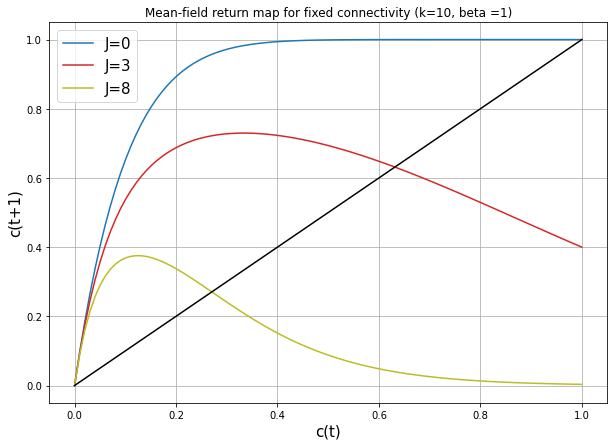

In [4]:
k = 10   # Fixed degree
beta = 1
J_list = np.array([0, 3, 8])
c_list = np.linspace(0, 1, 100)

plt.figure(figsize=(10,7))
for J in J_list:
    c1_list = np.array([])
    for c in c_list:
        beta_risk = beta*risk(J, 1, c)
        c1_list = np.append(c1_list, SIS_hom(k, c, beta_risk))
    plt.plot(c_list, c1_list, color='C'+str(J), label='J='+str(J))
plt.plot(c_list,c_list, color='black')
plt.xlabel('c(t)', fontsize=15)
plt.ylabel('c(t+1)', fontsize=15)
plt.title(f'Mean-field return map for fixed connectivity (k={k}, beta ={beta})')
plt.legend(fontsize=15)
plt.grid()

#### Critical value of precaution level J w.r.t bare infectivity for a Poissonian network (Erdos-Reny) in mean field approximation 

/home/marco/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/marco/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


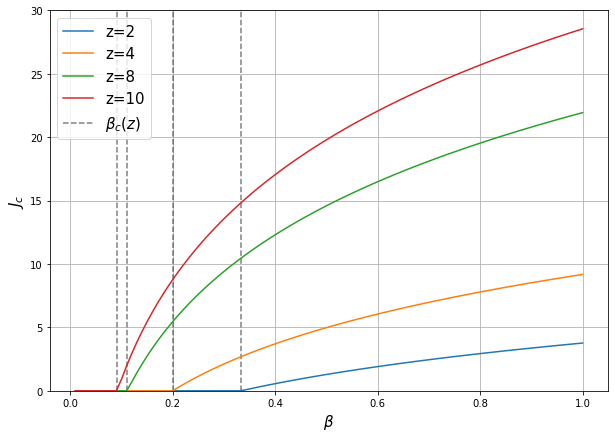

In [5]:
beta_list = np.linspace(0.01, 1, 100)
z_list = np.array([2,4,8,10])
alpha = 1

plt.figure(figsize=(10,7))
J_critical_list = np.array([])
for z in z_list:
    for beta in beta_list:
        sol = fsolve(critical_boundary, 0, args=(beta, z, alpha), full_output=False)
        J_critical_list = np.append(J_critical_list, sol)
        if J_critical_list[-1] < 0:
            J_critical_list[-1] = 0
    plt.plot(beta_list, J_critical_list, label=f'z={z}')
    # same color for the dashed line
    plt.vlines(z/(z+z**2), 0, 100, linestyles='dashed', colors='black', alpha=0.5)
    # save the last results
    if z == z_list[-1]:
        J_critical_list_poiss = J_critical_list
        beta_list_poiss = beta_list
    J_critical_list = np.array([])
plt.xlabel(r'$\beta$', fontsize=15)
plt.ylabel(r'$J_c$', fontsize=15)
plt.ylim(0, 30)
plt.legend(['z=2', 'z=4', 'z=8', 'z=10', r'$\beta_c(z)$'], fontsize=15)
plt.grid()

#### Critical value Jc for 4 different networks (fixed and poisson analytically; lattice and fully rewired numerically) with mean degree z=10

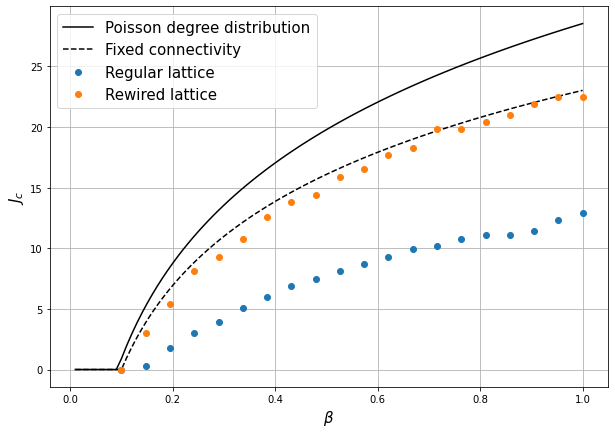

In [6]:
# ~20min

# consider networks with 1000 nodes and average degree z=10
N = 1000
z = 10

# Regular lattice
p = 0
G_reg = nx.watts_strogatz_graph(N, z, p)

# Fully rewired lattice
p = 1
G_rew = nx.watts_strogatz_graph(N, z, p)

# Maximum number of iterations of dynamics
N_iter = 500
# Initial number of infected nodes
m = 10
# tolerance for convergence
tol = 0.001

# Epidemic parameters
beta_list = np.linspace(0.1, 1, 20)
J_list = np.arange(30, 0, -0.3)

# Compute mean and variance of the critical boundary over N_sim realizations
N_sim = 1

# Compute the critical boundary for the regular lattice and the fully rewired lattice
if N_sim == 1:
    J_critical_reg = numerical_Jc(N_sim, beta_list, J_list, True, SIS_dynamics, net=G_reg, N_iter=N_iter, m=m, risk=risk, tol=tol)
    J_critical_rew = numerical_Jc(N_sim, beta_list, J_list, True, SIS_dynamics, net=G_rew, N_iter=N_iter, m=m, risk=risk, tol=tol)
else:
    J_critical_reg_mean, J_critical_reg_var = numerical_Jc(N_sim, beta_list, J_list, True, SIS_dynamics, net=G_reg, N_iter=N_iter, m=m, risk=risk, tol=tol)
    J_critical_rew_mean, J_critical_rew_var = numerical_Jc(N_sim, beta_list, J_list, True, SIS_dynamics, net=G_rew, N_iter=N_iter, m=m, risk=risk, tol=tol)

# plot
# error bars
plt.figure(figsize=(10,7))
if N_sim == 1:
    plt.errorbar(beta_list, J_critical_reg, label='Regular lattice', fmt='o')
    plt.errorbar(beta_list, J_critical_rew, label='Rewired lattice', fmt='o')
else:
    plt.errorbar(beta_list, J_critical_reg_mean, yerr=J_critical_reg_var, label='Regular lattice', fmt='o')
    plt.errorbar(beta_list, J_critical_rew_mean, yerr=J_critical_rew_var, label='Rewired lattice', fmt='o')

# add to the plt the critical boundary for the poisson degree distribution
plt.plot(beta_list_poiss, J_critical_list_poiss, label='Poisson degree distribution', color='black')
# add to the plt the critical boundary for fixed connectivity
plt.plot(beta_list_poiss, SIS_hom_critical_J(beta_list_poiss, z), label='Fixed connectivity', color='black', linestyle='dashed')
plt.xlabel(r'$\beta$', fontsize=15)
plt.ylabel(r'$J_c$', fontsize=15)
plt.legend(fontsize=15)
plt.grid()

#### Fraction of time spent ill in the scale-free case as a function of degree k

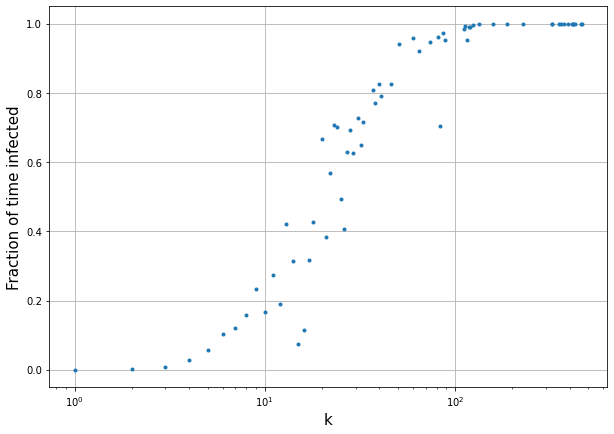

In [7]:
# Instantiate the free scale network
N = 1000
K = 10
G_fs = FS_Bagnoli(N, K, 27)

# run the SIS dynamics for the free scale network
J = 10
beta = 1
N_iter = 1000
m = 10
time, degree = SIS_dynamics(G_fs, J, N_iter, m, beta, risk, count_time=True)

# plot the time of infection for each node with respect to the degree
plt.figure(figsize=(10,7))
plt.plot(degree, time, '.')
plt.xlabel('k', fontsize=15)
plt.ylabel('Fraction of time infected', fontsize=15)
plt.xscale('log')
plt.grid()


#### Critical value of risk perception J for the free scale network as a function of alpha

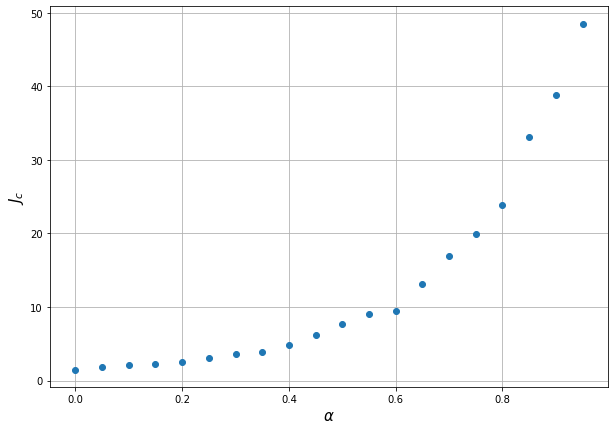

In [8]:
# ~40min

N = 1000
K = 4
G_fs = FS_Bagnoli(N, K, 0)

N_iter = 1000
tol = 0.001

m = 10
beta = 1
J_list = np.linspace(75, 0, 500)
alpha_list = np.linspace(0, 0.95, 20)

N_sim = 1
# Compute the critical boundary for the free scale network
if N_sim == 1:
    J_critical_fs = numerical_Jc(N_sim, alpha_list, J_list, False, SIS_dynamics, net=G_fs, N_iter=N_iter, m=m, beta=beta, risk=risk, tol=tol)
else:
    J_critical_fs_mean, J_critical_fs_var = numerical_Jc(N_sim, alpha_list, J_list, False, SIS_dynamics, net=G_fs, N_iter=N_iter, m=m, beta=beta, risk=risk, tol=tol)

# plot
# error bars
plt.figure(figsize=(10,7))
if N_sim == 1:
    plt.errorbar(alpha_list, J_critical_fs, fmt='o')
else:
    plt.errorbar(alpha_list, J_critical_fs_mean, yerr=J_critical_fs_var, fmt='o')
plt.xlabel(r'$\alpha$', fontsize=15)
plt.ylabel(r'$J_c$', fontsize=15)
plt.grid()